In [1]:
import torch
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import math
from PIL import Image
import torch.nn as nn
import yaml
device = "cuda" if torch.cuda.is_available() else "cpu" # 檢查是否有可用的 CUDA 設備（通常是顯卡，支援 GPU 運算），如果有，就將 device 變數設置為 "cuda"，否則設置為 "cpu"。

In [2]:


def load_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config


In [3]:

file_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/config.yml'
config = load_config(file_path)

In [4]:
# img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Simple_DE/Image_Sample/2011_09_26_drive_0002_sync_image_0000000005_image_02.png")


In [5]:
target_size = (config['data']['image_size'], config['data']['image_size'])
# img = cv2.resize(img, target_size)
# img.shape

# cv2_imshow(img)

In [6]:
target_size

(256, 256)

In [7]:
def image_folder_to_tensor(folder_path):

    images_list = []

    # 获取文件夹中所有文件的列表
    # files = os.listdir(folder_path)
    files = sorted(os.listdir(folder_path))

    for file in files:

        file_path = os.path.join(folder_path, file)

        img = cv2.imread(file_path)
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_LANCZOS4)
        images_list.append(img)



    img2 = np.stack(images_list, axis=0)
    tensor = torch.tensor(img2)

    tensor = tensor.to(torch.float16)


    tensor = tensor / 255.0
    tensor = tensor * 2.0
    tensor = tensor - 1.0
    tensor = tensor.permute(0, 3, 1, 2)
    # output = torch.tensor(img2)
    # output = output.permute(0, 3, 1, 2)

    # output = tensor


    return tensor




In [8]:
def image_tensor_to_numpy(tensor):

    tensor = tensor.permute(0, 2, 3, 1)
    output = tensor.numpy()
    output = output + 1.0
    output = output / 2.0
    output = output * 255.0
    output = output.astype(np.uint8)



    return output



In [9]:
# folder_path = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/image"
folder_path = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/Image_Sample"
img = image_folder_to_tensor(folder_path)
img.shape

torch.Size([10, 3, 256, 256])

In [10]:
# test = torch.tensor([0, 1, 2])
# non_zero_min = torch.min(test[test != 0])
# non_zero_min


In [11]:
# this is min max normalize
'''
def depth_folder_to_tensor(folder_path):

    images_list = []



    files = sorted(os.listdir(folder_path))

    for file in files:

        file_path = os.path.join(folder_path, file)
        depth = np.array(Image.open(file_path), dtype=np.int16)
        assert(np.max(depth) > 255)
        depth = cv2.resize(depth, target_size, cv2.INTER_LANCZOS4)
        depth = depth.astype(np.float16) / 256.0
        images_list.append(depth)



    img2 = np.stack(images_list, axis=0)
    tensor = torch.tensor(img2)

    mini = torch.min(tensor[tensor != 0])
    tensor = (tensor - mini) / (tensor.max() - mini)
    tensor = torch.where(tensor < 0, -1, tensor)






    return tensor
'''

'\ndef depth_folder_to_tensor(folder_path):\n\n    images_list = []\n\n\n\n    files = sorted(os.listdir(folder_path))\n\n    for file in files:\n\n        file_path = os.path.join(folder_path, file)\n        depth = np.array(Image.open(file_path), dtype=np.int16)\n        assert(np.max(depth) > 255)\n        depth = cv2.resize(depth, target_size, cv2.INTER_LANCZOS4)\n        depth = depth.astype(np.float16) / 256.0\n        images_list.append(depth)\n\n\n\n    img2 = np.stack(images_list, axis=0)\n    tensor = torch.tensor(img2)\n\n    mini = torch.min(tensor[tensor != 0])\n    tensor = (tensor - mini) / (tensor.max() - mini)\n    tensor = torch.where(tensor < 0, -1, tensor)\n\n\n\n\n\n\n    return tensor\n'

In [12]:
# this is z-score normalization

def depth_folder_to_tensor(folder_path):

    images_list = []



    files = sorted(os.listdir(folder_path))

    for file in files:

        file_path = os.path.join(folder_path, file)
        depth = np.array(Image.open(file_path), dtype=np.int16)
        assert(np.max(depth) > 255)
        depth = cv2.resize(depth, target_size, cv2.INTER_LANCZOS4)
        depth = depth.astype(np.float16) / 256.0
        images_list.append(depth)



    img2 = np.stack(images_list, axis=0)
    tensor = torch.tensor(img2)
    nonzero_mask = tensor != 0
    zero_mask = tensor == 0
    mean = tensor[nonzero_mask].mean()
    std = tensor[nonzero_mask].std()
    result = (tensor[nonzero_mask] - mean) / std
    tensor[nonzero_mask] = result
    tensor[zero_mask] = -1



    return tensor, mean, std

In [13]:
# file_path = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/groundtruth_depth/2011_09_26_drive_0002_sync_groundtruth_depth_0000000005_image_02.png"
# depth = np.array(Image.open(file_path), dtype=np.int16)
# assert(np.max(depth) > 255)
# # depth_png = depth_png.astype(np.int16)
# depth = cv2.resize(depth, target_size, cv2.INTER_LANCZOS4)
# depth = depth.astype(np.float16) / 256.0



# '''
# depth = cv2.resize(depth_png, target_size, cv2.INTER_LANCZOS4)
# depth = depth.astype(np.float32) / 256.
# cv2_imshow(depth)
# '''
# # print((depth_png.dtype))
# # images_list.append(depth)

In [14]:
# tensor = torch.tensor([[1, 0, 3], [0, 5, 6]])

# # 将张量内的所有零值替换为-1
# tensor_with_negative_one = torch.where(tensor == 0, -1, tensor)

# print("原始张量:")
# print(tensor)

# print("\n零值替换为-1后的张量:")
# print(tensor_with_negative_one)

In [15]:
# folder_path = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/groundtruth_depth"
folder_path = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/Depth_Sample"
dep, depth_mean, depth_std = depth_folder_to_tensor(folder_path)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, img, depth):
        self.img = img
        self.depth = depth

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        sample = {'img': self.img[idx], 'depth': self.depth[idx]}
        return sample




# 创建数据集实例
custom_dataset = CustomDataset(img, dep)

# 使用DataLoader加载数据集
batch_size = 32
batch_size = 8
batch_size = 2
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
count = 0
# 迭代DataLoader获取批次数据
for batch in data_loader:
    count = count + 1
    input_img = batch['img']
    target_depth = batch['depth']
    break
input_img.shape

torch.Size([2, 3, 256, 256])

In [17]:
dep.min()

tensor(-1., dtype=torch.float16)

In [18]:
img.min()

tensor(-1., dtype=torch.float16)

In [19]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/groundtruth_depth"
files = sorted(os.listdir(folder_path))

for file in files:

  file_path = os.path.join(folder_path, file)
  img = cv2.imread(file_path)
  print(type(img))
  break
folder_path = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/image"

files = sorted(os.listdir(folder_path))

for file in files:

  file_path = os.path.join(folder_path, file)
  img2 = cv2.imread(file_path)
  print(type(img))
  break




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


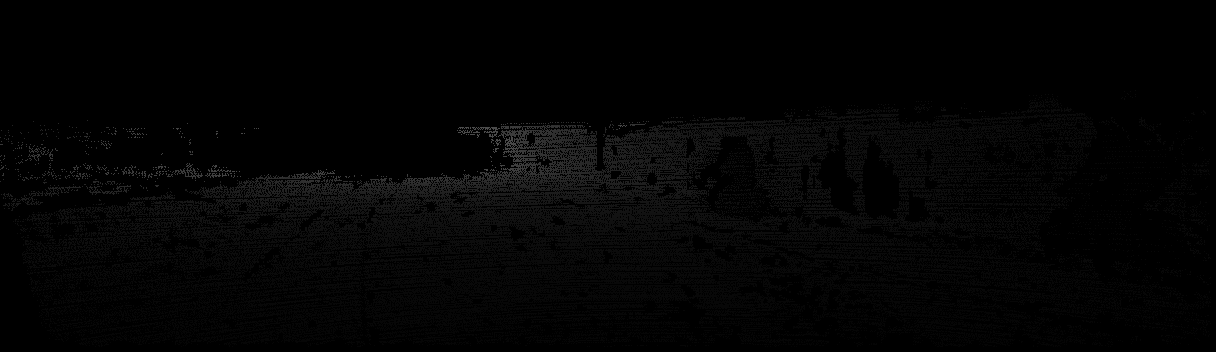

(array([ 90,  90,  90, ..., 346, 346, 346]), array([1135, 1135, 1135, ..., 1110, 1110, 1110]), array([0, 1, 2, ..., 0, 1, 2]))
10


In [20]:
nonzero_indices = np.nonzero(img)
cv2_imshow(img)
print(nonzero_indices)
print(img[90, 1135, 0])

In [21]:


filename = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/groundtruth_depth/2011_09_26_drive_0002_sync_groundtruth_depth_0000000005_image_02.png"
def depth_read(filename):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(np.float32) / 256.
    depth[depth_png == 0] = -1.
    return depth



In [22]:
test = depth_read(filename)
# test = np.array([1, 2])
# test.astype(np.float)

In [23]:
exclude = -1.0
masked_arr = test[test != exclude]
masked_arr.shape
mean = np.mean(masked_arr)
mean


15.930007

In [24]:
# class CustomDataset(Dataset):
#     def __init__(self, img, depth):
#         self.img = img
#         self.depth = depth

#     def __len__(self):
#         return len(self.img)

#     def __getitem__(self, idx):
#         sample = {'img': self.img[idx], 'depth': self.depth[idx]}
#         return sample




# # 创建数据集实例
# custom_dataset = CustomDataset(img, dep)

# # 使用DataLoader加载数据集
# batch_size = 32
# data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
# count = 0
# # 迭代DataLoader获取批次数据
# for batch in data_loader:
#     count = count + 1
#     input_img = batch['img']
#     target_depth = batch['depth']
#     break
# input_img.shape

In [25]:
def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    def sigmoid(x):
        return 1 / (np.exp(-x) + 1)

    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "sigmoid":
        betas = np.linspace(-6, 6, num_diffusion_timesteps)
        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas

In [26]:
config['diffusion']['beta_start']
beta_schedule = config['diffusion']['beta_schedule']
beta_start = config['diffusion']['beta_start']
beta_end = config['diffusion']['beta_end']
num_diffusion_timesteps = config['diffusion']['num_diffusion_timesteps']

In [27]:
beta = torch.tensor(get_beta_schedule(beta_schedule, beta_start = beta_start, beta_end = beta_end, num_diffusion_timesteps = num_diffusion_timesteps))
beta = beta.to(device)
print(beta.device)

cpu


In [28]:
def compute_alpha(beta, t): # t給tensor 一維的
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a


In [29]:
def get_timestep_embedding(timesteps, embedding_dim):

    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

In [30]:
timesteps = torch.tensor([0, 1, 2, 3, 5])
test = get_timestep_embedding(timesteps, 4)
test

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  1.0000e-04,  5.4030e-01,  1.0000e+00],
        [ 9.0930e-01,  2.0000e-04, -4.1615e-01,  1.0000e+00],
        [ 1.4112e-01,  3.0000e-04, -9.8999e-01,  1.0000e+00],
        [-9.5892e-01,  5.0000e-04,  2.8366e-01,  1.0000e+00]])

In [31]:
def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)

In [32]:
def nonlinearity(x):

    return x*torch.sigmoid(x)

In [33]:
class Upsample(nn.Module): # this
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,  # this conv let the size unchanged
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(
            x, scale_factor=2.0, mode="nearest") # double the size
        if self.with_conv:
            x = self.conv(x)
        return x

In [34]:
class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,  # halves the size
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0) # 此動作相當於在每個圖片的channel的右邊下面pad 0
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x

In [35]:

class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.temb_channels = temb_channels
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)     # 這裡上面define的Normalize有點像是class的感覺
        self.conv1 = torch.nn.Conv2d(in_channels, # size unchanged
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        self.temb_proj = torch.nn.Linear(temb_channels,
                                         out_channels)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout) # param為機率
        self.conv2 = torch.nn.Conv2d(out_channels, # size unchanged
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,   # size unchanged
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,    # size unchanged
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)

    def forward(self, x, temb):
        # print("in = {}".format(self.in_channels))
        # print("out = {}".format(self.out_channels))
        # print("x.shape = {}".format(x.shape))
        # print("temb.shape = {}".format(temb.shape))
        # print("temb_channel = {}".format(self.temb_channels))
        h = x
        h = self.norm1(h)    # normalize
        h = nonlinearity(h)  # sigmoid
        h = self.conv1(h)    # channel become out_channel
        # print("h.shape = {}".format(h.shape))
        # print("self.temb_proj(nonlinearity(temb)).shape = {}".format(self.temb_proj(nonlinearity(temb)).shape))
        # print("temb_proj(nonlinearity(temb))[:, :, None, None].shape = {}".format(self.temb_proj(nonlinearity(temb))[:, :, None, None].shape))
        h = h + self.temb_proj(nonlinearity(temb))[:, :, None, None] # 後面加入None增加空的維度，針對temb_proj(nonlinearity(temb))使用，使其可以跟h相加，但是是使用broadcasting的方式
        # temb是什麼 是用來做positional embedding的嗎????????

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:  # 如果inchannel和outchannel不同需要把輸入值channel也調整成一樣，用上conv2D，若inchannel和outchannel一樣就直接加
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h

In [36]:
class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels, # in_cha == out_cha and the kernel size = 1, and size unchanged
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q.shape # (batch, channel, height, width)
        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)   # b,hw,c.  # 此兩變換(reshape + permute)詳細情形如下格，簡單來說最外圈還是每一個data(一張照片)，
                                # 往內一圈則是把該資料的所有channel(rgb)的同個位置放在一起
        k = k.reshape(b, c, h*w)  # b,c,hw # 單一此變換則是外圈是data，向內一圈則是該data一個channel內所有的值
        w_ = torch.bmm(q, k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        # 注意這邊是q * k，是把不同channels的同個位置變成vector然後內積，這樣跟cnn最大的差別是cnn只會在同一個區塊做相關性，attention卻在channels中的每個位置會相互做相關性
        w_ = w_ * (int(c)**(-0.5)) # 為何不是 * (int(h * w) ** (-0.5))?
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b, c, h*w)
        w_ = w_.permute(0, 2, 1)   # b,hw,hw (first hw of k, second of q)
        # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = torch.bmm(v, w_)
        h_ = h_.reshape(b, c, h, w)

        h_ = self.proj_out(h_)

        return x+h_

In [37]:
def get_index_from_list(values, t, x_shape):
    batch_size = t.shape[0]
    """
    pick the values from vals
    according to the indices stored in `t`
    """
    result = values.gather(-1, t.cpu())
    """
    if
    x_shape = (5, 3, 64, 64)
        -> len(x_shape) = 4
        -> len(x_shape) - 1 = 3

    and thus we reshape `out` to dims
    (batch_size, 1, 1, 1)

    """
    return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [38]:
class DiffusionModel:
    def __init__(self, beta_schedule = 'linear', start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        betas = get_beta_schedule(beta_schedule, beta_start = start_schedule, beta_end = end_schedule, num_diffusion_timesteps = timesteps)
        self.betas = torch.tensor(betas)


        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """

        noise = torch.randn_like(x_0)
        print("alphas_cumprod.sqrt().dtype = {}".format(self.alphas_cumprod.sqrt().dtype) )
        sqrt_alphas_cumprod_t = get_index_from_list(self.alphas_cumprod.sqrt(), t.to(torch.int64), x_0.shape)

        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t.to(torch.int64), x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device) # mean為x_0乘以alpha bar, variance 為 noise 乘以 1-alpha bar


In [39]:
class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        ch, out_ch, ch_mult = config['model']['ch'], config['model']['out_ch'], tuple(config['model']['ch_mult'])
        num_res_blocks = config['model']['num_res_blocks']
        attn_resolutions = config['model']['attn_resolutions']
        dropout = config['model']['dropout']
        in_channels = config['model']['in_channels']
        resolution = config['data']['image_size']
        resamp_with_conv = config['model']['resamp_with_conv']
        num_timesteps = config['diffusion']['num_diffusion_timesteps']

        if config['model']['type'] == 'bayesian':
            self.logvar = nn.Parameter(torch.zeros(num_timesteps))

        self.ch = ch
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # timestep embedding
        self.temb = nn.Module()
        self.temb.dense = nn.ModuleList([
            torch.nn.Linear(self.ch,
                            self.temb_ch),
            torch.nn.Linear(self.temb_ch,
                            self.temb_ch),
        ])

        '''
        # timestep embedding for diffusion---vvv
        self.temb.diff1 = nn.Linear(1, 1)
        self.temb.diff2 = nn.Linear(1, 1)
        # timestep embedding for diffusion---^^^
        '''
        # diffusion process ---vvv
        self.beta_schedule = config['diffusion']['beta_schedule']
        self.start_schedule = config['diffusion']['beta_start']
        self.end_schedule = config['diffusion']['beta_end']
        self.timesteps = config['diffusion']['num_diffusion_timesteps']
        self.diffusion_process = DiffusionModel(self.beta_schedule, self.start_schedule, self.end_schedule, self.timesteps)
        # diffusion process ---^^^



        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+ch_mult
        self.down = nn.ModuleList()
        block_in = None
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level] # 最後一個block時inchannel數可能變少
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up)  # prepend to get consistent order, (0, up)代表在ModuleList()的0位置插入up這個Module

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, image, depth, t):
        # assert x.shape[2] == x.shape[3] == self.resolution # to check if the height and width are the same with the resolution

        # timestep embedding
        temb = get_timestep_embedding(t, self.ch)
        temb = self.temb.dense[0](temb)
        temb = nonlinearity(temb)
        temb = self.temb.dense[1](temb)



        # diffusion process ---vvv

        noisy_map, noise = self.diffusion_process.forward(depth, t, device = t.device)
        # diffusion process ---^^^




        # downsampling down 裡面有好幾個元素，每個元素包含block(resblock), attn, downsample，其中attn只有幾個元素會有，downsample除了最後一個元素以外都有
        # 整個流程就是把x送進conv2D 然後送進down裡面經過resblock和部份attn downsample(conv2D)
        hs = [self.conv_in(image)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb) # h 如果可以是attn就是attn 不然就是res, note that h是把值喂進去模塊後的值，要把hs的最後跟time embedded送進去
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](torch.cat([h, hs.pop()], dim=1), temb) # u-net的cat down
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

In [40]:
class Model_test(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        ch, out_ch, ch_mult = config['model']['ch'], config['model']['out_ch'], tuple(config['model']['ch_mult'])
        num_res_blocks = config['model']['num_res_blocks']
        attn_resolutions = config['model']['attn_resolutions']
        dropout = config['model']['dropout']
        in_channels = config['model']['in_channels']
        resolution = config['data']['image_size']
        resamp_with_conv = config['model']['resamp_with_conv']
        num_timesteps = config['diffusion']['num_diffusion_timesteps']

        if config['model']['type'] == 'bayesian':
            self.logvar = nn.Parameter(torch.zeros(num_timesteps))

        self.ch = ch
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # timestep embedding
        self.temb = nn.Module()
        self.temb.dense = nn.ModuleList([
            torch.nn.Linear(self.ch,
                            self.temb_ch),
            torch.nn.Linear(self.temb_ch,
                            self.temb_ch),
        ])

        '''
        # timestep embedding for diffusion---vvv
        self.temb.diff1 = nn.Linear(1, 1)
        self.temb.diff2 = nn.Linear(1, 1)
        # timestep embedding for diffusion---^^^
        '''
        # diffusion process ---vvv
        self.beta_schedule = config['diffusion']['beta_schedule']
        self.start_schedule = config['diffusion']['beta_start']
        self.end_schedule = config['diffusion']['beta_end']
        self.timesteps = config['diffusion']['num_diffusion_timesteps']
        self.diffusion_process = DiffusionModel(self.beta_schedule, self.start_schedule, self.end_schedule, self.timesteps)
        # diffusion process ---^^^



        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+ch_mult
        self.down = nn.ModuleList()
        block_in = None
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level] # 最後一個block時inchannel數可能變少
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up)  # prepend to get consistent order, (0, up)代表在ModuleList()的0位置插入up這個Module

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, image, depth, t):
        # assert x.shape[2] == x.shape[3] == self.resolution # to check if the height and width are the same with the resolution

        # timestep embedding
        temb = get_timestep_embedding(t, self.ch)
        temb = self.temb.dense[0](temb)
        temb = nonlinearity(temb)
        temb = self.temb.dense[1](temb)



        # diffusion process ---vvv

        noisy_map, noise = self.diffusion_process.forward(depth, t, device = t.device)
        # diffusion process ---^^^




        # downsampling down 裡面有好幾個元素，每個元素包含block(resblock), attn, downsample，其中attn只有幾個元素會有，downsample除了最後一個元素以外都有
        # 整個流程就是把x送進conv2D 然後送進down裡面經過resblock和部份attn downsample(conv2D)
        hs = [self.conv_in(image)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb) # h 如果可以是attn就是attn 不然就是res, note that h是把值喂進去模塊後的值，要把hs的最後跟time embedded送進去
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](torch.cat([h, hs.pop()], dim=1), temb) # u-net的cat down
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

In [54]:
class Model_test2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        ch, out_ch, ch_mult = config['model']['ch'], config['model']['out_ch'], tuple(config['model']['ch_mult'])
        num_res_blocks = config['model']['num_res_blocks']
        attn_resolutions = config['model']['attn_resolutions']
        dropout = config['model']['dropout']
        in_channels = config['model']['in_channels']
        resolution = config['data']['image_size']
        resamp_with_conv = config['model']['resamp_with_conv']
        num_timesteps = config['diffusion']['num_diffusion_timesteps']

        if config['model']['type'] == 'bayesian':
            self.logvar = nn.Parameter(torch.zeros(num_timesteps))

        self.ch = ch
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # timestep embedding
        self.temb = nn.Module()
        self.temb.dense = nn.ModuleList([
            torch.nn.Linear(self.ch,
                            self.temb_ch),
            torch.nn.Linear(self.temb_ch,
                            self.temb_ch),
        ])

        '''
        # timestep embedding for diffusion---vvv
        self.temb.diff1 = nn.Linear(1, 1)
        self.temb.diff2 = nn.Linear(1, 1)
        # timestep embedding for diffusion---^^^
        '''
        # diffusion process ---vvv
        self.beta_schedule = config['diffusion']['beta_schedule']
        self.start_schedule = config['diffusion']['beta_start']
        self.end_schedule = config['diffusion']['beta_end']
        self.timesteps = config['diffusion']['num_diffusion_timesteps']
        self.diffusion_process = DiffusionModel(self.beta_schedule, self.start_schedule, self.end_schedule, self.timesteps)
        # diffusion process ---^^^



        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+ch_mult
        self.down = nn.ModuleList()
        block_in = None
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level] # 最後一個block時inchannel數可能變少
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up)  # prepend to get consistent order, (0, up)代表在ModuleList()的0位置插入up這個Module

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)
        self.conv_merge = torch.nn.Conv2d(out_ch,
                                          1,
                                          kernel_size = 3,
                                          stride = 1,
                                          padding = 1)

    def forward(self, image, depth, t):
        # assert x.shape[2] == x.shape[3] == self.resolution # to check if the height and width are the same with the resolution

        # timestep embedding
        temb = get_timestep_embedding(t, self.ch)
        temb = self.temb.dense[0](temb)
        temb = nonlinearity(temb)
        temb = self.temb.dense[1](temb)



        # diffusion process ---vvv

        noisy_map, noise = self.diffusion_process.forward(depth, t, device = t.device)
        # diffusion process ---^^^




        # downsampling down 裡面有好幾個元素，每個元素包含block(resblock), attn, downsample，其中attn只有幾個元素會有，downsample除了最後一個元素以外都有
        # 整個流程就是把x送進conv2D 然後送進down裡面經過resblock和部份attn downsample(conv2D)
        hs = [self.conv_in(image)]

        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb) # h 如果可以是attn就是attn 不然就是res, note that h是把值喂進去模塊後的值，要把hs的最後跟time embedded送進去
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](torch.cat([h, hs.pop()], dim=1), temb) # u-net的cat down
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        h = self.conv_merge(h)
        h = h.squeeze(dim = 1)
        h = torch.cat([h, noisy_map], dim = 0)
        return h, noisy_map, noise

In [55]:
model = Model_test2(config)
model.to(device)
t = torch.tensor([1, 2])
input_img = input_img.to(torch.float32)
input_img.to(device)
t = t.to(torch.float32)
t = t.to(device)

In [56]:
ans, noisy_map, noise = model(input_img, target_depth, t)


alphas_cumprod.sqrt().dtype = torch.float64


In [57]:
print("ans.shape = {}".format(ans.shape))
print("noisy_map.shape = {}".format(noisy_map.shape))
print("noise.shape = {}".format(noise.shape))

ans.shape = torch.Size([4, 256, 256])
noisy_map.shape = torch.Size([2, 256, 256])
noise.shape = torch.Size([2, 256, 256])


In [52]:
del ans, noisy_map, noise


In [ ]:
'''
這樣concat很怪 應該是希望2x256x256跟2x256x256 concat成為2x2x256x256
其中dim為(batch, channel, height, width)
channel為2代表把depth和condition concat起來
'''

In [46]:
model

Model_test2(
  (temb): Module(
    (dense): ModuleList(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0-1): 2 x Module(
      (block): ModuleList(
        (0-1): 2 x ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (temb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleList()
      (downsample): Downsample(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
      )
    )
    (2): Module(
      (block): ModuleL

torch.Size([32, 128, 256, 256])

In [ ]:
# to do next 建構兩個模型 一個送image 一個把depth做diffusion動作後兩者合併再送進一個model後算loss

In [ ]:
ch_mult = config['model']['ch_mult']
tuple(ch_mult)

(1, 1, 2, 2, 4, 4)

In [ ]:
in_ch_mult = (1,)+tuple(ch_mult)
in_ch_mult

(1, 1, 1, 2, 2, 4, 4)

In [ ]:
for batch in data_loader:
    count = count + 1
    target_img = batch['img']
    target_depth = batch['depth']
    break
target_depth.shape

torch.Size([32, 256, 256])

In [ ]:
target_depth.min()

tensor(-1., dtype=torch.float16)

In [ ]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/Image_Sample"
test = image_folder_to_tensor(folder_path)
test.shape

torch.Size([10, 3, 256, 256])

In [ ]:
'''
def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    def sigmoid(x):
        return 1 / (np.exp(-x) + 1)

    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "sigmoid":
        betas = np.linspace(-6, 6, num_diffusion_timesteps)
        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas
'''

'\ndef get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):\n    def sigmoid(x):\n        return 1 / (np.exp(-x) + 1)\n\n    if beta_schedule == "quad":\n        betas = (\n            np.linspace(\n                beta_start ** 0.5,\n                beta_end ** 0.5,\n                num_diffusion_timesteps,\n                dtype=np.float64,\n            )\n            ** 2\n        )\n    elif beta_schedule == "linear":\n        betas = np.linspace(\n            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64\n        )\n    elif beta_schedule == "const":\n        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)\n    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1\n        betas = 1.0 / np.linspace(\n            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64\n        )\n    elif beta_schedule == "sigmoid":\n        betas = np.linspace(-6, 6, num_diffusion_timesteps)\n        betas

In [ ]:
def compute_alpha(beta, t): # t給tensor 一維的
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a

In [ ]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        betas = get_beta_schedule(beta_schedule, beta_start = start_schedule, beta_end = end_schedule, num_diffusion_timesteps = timesteps)
        self.betas = torch.tensor(betas)


        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device) # mean為x_0乘以alpha bar, variance 為 noise 乘以 1-alpha bar




In [ ]:
diff = DiffusionModel()
x_0 = target_depth
t = torch.randint(low = 1, high = 300, size = (32,))

In [ ]:
test1, test2 = diff.forward(x_0, t, device)


In [ ]:
test2.shape

torch.Size([32, 256, 256])

In [ ]:
beta_schedule = "linear"
start_schedule = 0.0002
end_schedule = 0.2
timesteps = 1000
betas = get_beta_schedule(beta_schedule, beta_start = start_schedule, beta_end = end_schedule, num_diffusion_timesteps = timesteps)

In [ ]:
type(betas)

numpy.ndarray

In [ ]:
alphas_temp = 1 - betas

In [ ]:
alphas = torch.tensor(alphas_temp)

In [ ]:
alphas.shape

torch.Size([1000])

In [ ]:
alphas_cumprod = torch.cumprod(alphas, axis=0)

In [ ]:
diff = DiffusionModel()

In [ ]:
# target = torch.tensor([[[[1, 2], [3, 4]], [[5, 6], [7, 8]], [[9, 10], [11, 12]]], [[[13, 14], [15, 16]], [[17, 18], [19, 20]], [[21, 22], [23, 24]]], [[[25, 26], [27, 28]], [[29, 30], [31, 32]], [[33, 34], [35, 36]]], [[[37, 38], [39, 40]], [[41, 42], [43, 44]], [[45, 46], [47, 48]]]], dtype = torch.float16)
# target.dtype
depth_tensor = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]], [[9, 10], [11, 12]], [[1, 0], [0, 0]]], dtype = torch.float16)
# depth_tensor.shape
nonzero_mask = depth_tensor != 0
zero_mask = depth_tensor == 0
mean = depth_tensor[nonzero_mask].mean()
std = depth_tensor[nonzero_mask].std()
result = (depth_tensor[nonzero_mask] - mean) / std
print(depth_tensor,  "\n-----")
depth_tensor[nonzero_mask] = result
# norm_depth = (depth_tensor - mean) / std
# mean = target.mean(dim=(0, 2, 3), keepdim=True)
depth_tensor[zero_mask] = -1
print(depth_tensor)

tensor([[[ 1.,  2.],
         [ 3.,  4.]],

        [[ 5.,  6.],
         [ 7.,  8.]],

        [[ 9., 10.],
         [11., 12.]],

        [[ 1.,  0.],
         [ 0.,  0.]]], dtype=torch.float16) 
-----
tensor([[[-1.3457, -1.0811],
         [-0.8159, -0.5508]],

        [[-0.2856, -0.0207],
         [ 0.2443,  0.5093]],

        [[ 0.7744,  1.0391],
         [ 1.3047,  1.5693]],

        [[-1.3457, -1.0000],
         [-1.0000, -1.0000]]], dtype=torch.float16)


In [ ]:
x = torch.tensor([[1, 0, 2], [0, 3, 0], [4, 0, 5]])
nonzero_mask = x != 0
result = x[nonzero_mask] + 2
x[nonzero_mask] = result
print(x)

tensor([[3, 0, 4],
        [0, 5, 0],
        [6, 0, 7]])


In [ ]:
depth_tensor[nonzero_mask]

IndexError: The shape of the mask [3, 3] at index 0 does not match the shape of the indexed tensor [4, 2, 2] at index 0

In [ ]:
'''
@DATASETS.register_module()
class KITTIDataset(Dataset):
    """KITTI dataset for depth estimation. An example of file structure
    is as followed.
    .. code-block:: none
        ├── data
        │   ├── KITTI
        │   │   ├── kitti_eigen_train.txt
        │   │   ├── kitti_eigen_test.txt
        │   │   ├── input (RGB, img_dir)
        │   │   │   ├── date_1
        │   │   │   ├── date_2
        │   │   │   |   ...
        │   │   │   |   ...
        |   │   ├── gt_depth (ann_dir)
        │   │   │   ├── date_drive_number_sync
    split file format:
    input_image: 2011_09_26/2011_09_26_drive_0002_sync/image_02/data/0000000069.png
    gt_depth:    2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/0000000069.png
    focal:       721.5377 (following the focal setting in BTS, but actually we do not use it)
    Args:
        pipeline (list[dict]): Processing pipeline
        img_dir (str): Path to image directory
        ann_dir (str, optional): Path to annotation directory. Default: None
        split (str, optional): Split txt file. Split should be specified, only file in the splits will be loaded.
        data_root (str, optional): Data root for img_dir/ann_dir. Default: None.
        test_mode (bool): If test_mode=True, gt wouldn't be loaded.
        depth_scale=256: Default KITTI pre-process. divide 256 to get gt measured in meters (m)
        garg_crop=True: Following Adabins, use grag crop to eval results.
        eigen_crop=False: Another cropping setting.
        min_depth=1e-3: Default min depth value.
        max_depth=80: Default max depth value.
    """


    def __init__(self,
                 pipeline,
                 img_dir,
                 ann_dir=None,
                 split=None,
                 data_root=None,
                 test_mode=False,
                 depth_scale=256,
                 garg_crop=True,
                 eigen_crop=False,
                 min_depth=1e-3,
                 max_depth=80):

        self.pipeline = Compose(pipeline)
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.split = split
        self.data_root = data_root
        self.test_mode = test_mode
        self.depth_scale = depth_scale
        self.garg_crop = garg_crop
        self.eigen_crop = eigen_crop
        self.min_depth = min_depth # just for evaluate. (crop gt to certain range)
        self.max_depth = max_depth # just for evaluate.

        # join paths if data_root is specified
        if self.data_root is not None:
            if not (self.img_dir is None or osp.isabs(self.img_dir)):
                self.img_dir = osp.join(self.data_root, self.img_dir)
            if not (self.ann_dir is None or osp.isabs(self.ann_dir)):
                self.ann_dir = osp.join(self.data_root, self.ann_dir)
            if not (self.split is None or osp.isabs(self.split)):
                self.split = osp.join(self.data_root, self.split)

        # load annotations
        self.img_infos = self.load_annotations(self.img_dir, self.ann_dir, self.split)


    def __len__(self):
        """Total number of samples of data."""
        return len(self.img_infos)

    def load_annotations(self, img_dir, ann_dir, split):
        """Load annotation from directory.
        Args:
            img_dir (str): Path to image directory
            ann_dir (str|None): Path to annotation directory.
            split (str|None): Split txt file. Split should be specified, only file in the splits will be loaded.
        Returns:
            list[dict]: All image info of dataset.
        """

        self.invalid_depth_num = 0
        img_infos = []
        if split is not None:
            with open(split) as f:
                for line in f:
                    img_info = dict()
                    if ann_dir is not None: # benchmark test or unsupervised future
                        depth_map = line.strip().split(" ")[1]
                        if depth_map == 'None':
                            self.invalid_depth_num += 1
                            continue
                        img_info['ann'] = dict(depth_map=depth_map)
                    img_name = line.strip().split(" ")[0]
                    img_info['filename'] = img_name
                    img_infos.append(img_info)
        else:
            print("Split should be specified, NotImplementedError")
            raise NotImplementedError

        # github issue:: make sure the same order
        img_infos = sorted(img_infos, key=lambda x: x['filename'])
        print_log(f'Loaded {len(img_infos)} images. Totally {self.invalid_depth_num} invalid pairs are filtered', logger=get_root_logger())

        return img_infos

    def get_ann_info(self, idx):
        """Get annotation by index.
        Args:
            idx (int): Index of data.
        Returns:
            dict: Annotation info of specified index.
        """

        return self.img_infos[idx]['ann']

    def pre_pipeline(self, results):
        """Prepare results dict for pipeline."""
        results['depth_fields'] = []
        results['img_prefix'] = self.img_dir
        results['depth_prefix'] = self.ann_dir
        results['depth_scale'] = self.depth_scale

        results['cam_intrinsic_dict'] = {
            '2011_09_26' : [[7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
                            [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
                            [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]],
            '2011_09_28' : [[7.070493e+02, 0.000000e+00, 6.040814e+02, 4.575831e+01],
                            [0.000000e+00, 7.070493e+02, 1.805066e+02, -3.454157e-01],
                            [0.000000e+00, 0.000000e+00, 1.000000e+00, 4.981016e-03]],
            '2011_09_29' : [[7.183351e+02, 0.000000e+00, 6.003891e+02, 4.450382e+01],
                            [0.000000e+00, 7.183351e+02, 1.815122e+02, -5.951107e-01],
                            [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.616315e-03]],
            '2011_09_30' : [[7.070912e+02, 0.000000e+00, 6.018873e+02, 4.688783e+01],
                            [0.000000e+00, 7.070912e+02, 1.831104e+02, 1.178601e-01],
                            [0.000000e+00, 0.000000e+00, 1.000000e+00, 6.203223e-03]],
            '2011_10_03' : [[7.188560e+02, 0.000000e+00, 6.071928e+02, 4.538225e+01],
                            [0.000000e+00, 7.188560e+02, 1.852157e+02, -1.130887e-01],
                            [0.000000e+00, 0.000000e+00, 1.000000e+00, 3.779761e-03]],
        }

    def __getitem__(self, idx):
        """Get training/test data after pipeline.
        Args:
            idx (int): Index of data.
        Returns:
            dict: Training/test data (with annotation if `test_mode` is set
                False).
        """

        if self.test_mode:
            return self.prepare_test_img(idx)
        else:
            return self.prepare_train_img(idx)

    def prepare_train_img(self, idx):
        """Get training data and annotations after pipeline.
        Args:
            idx (int): Index of data.
        Returns:
            dict: Training data and annotation after pipeline with new keys
                introduced by pipeline.
        """

        img_info = self.img_infos[idx]
        ann_info = self.get_ann_info(idx)
        results = dict(img_info=img_info, ann_info=ann_info)
        self.pre_pipeline(results)
        return self.pipeline(results)

    def prepare_test_img(self, idx):
        """Get testing data after pipeline.
        Args:
            idx (int): Index of data.
        Returns:
            dict: Testing data after pipeline with new keys introduced by
                pipeline.
        """

        img_info = self.img_infos[idx]
        results = dict(img_info=img_info)
        self.pre_pipeline(results)
        return self.pipeline(results)

    def format_results(self, results, imgfile_prefix=None, indices=None, **kwargs):
        """Place holder to format result to dataset specific output."""
        results[0] = (results[0] * self.depth_scale).astype(np.uint16)
        return results

    def get_gt_depth_maps(self):
        """Get ground truth depth maps for evaluation."""
        for img_info in self.img_infos:
            depth_map = osp.join(self.ann_dir, img_info['ann']['depth_map'])
            depth_map_gt = np.asarray(Image.open(depth_map), dtype=np.float32) / self.depth_scale
            yield depth_map_gt

    def eval_kb_crop(self, depth_gt):
        """Following Adabins, Do kb crop for testing"""
        height = depth_gt.shape[0]
        width = depth_gt.shape[1]
        top_margin = int(height - 352)
        left_margin = int((width - 1216) / 2)
        depth_cropped = depth_gt[top_margin: top_margin + 352, left_margin: left_margin + 1216]
        depth_cropped = np.expand_dims(depth_cropped, axis=0)
        return depth_cropped

    def eval_mask(self, depth_gt):
        """Following Adabins, Do grag_crop or eigen_crop for testing"""
        depth_gt = np.squeeze(depth_gt)
        valid_mask = np.logical_and(depth_gt > self.min_depth, depth_gt < self.max_depth)
        if self.garg_crop or self.eigen_crop:
            gt_height, gt_width = depth_gt.shape
            eval_mask = np.zeros(valid_mask.shape)

            if self.garg_crop:
                eval_mask[int(0.40810811 * gt_height):int(0.99189189 * gt_height),
                          int(0.03594771 * gt_width):int(0.96405229 * gt_width)] = 1

            elif self.eigen_crop:
                eval_mask[int(0.3324324 * gt_height):int(0.91351351 * gt_height),
                          int(0.0359477 * gt_width):int(0.96405229 * gt_width)] = 1
        valid_mask = np.logical_and(valid_mask, eval_mask)
        valid_mask = np.expand_dims(valid_mask, axis=0)
        return valid_mask

    def pre_eval(self, preds, indices):
        """Collect eval result from each iteration.
        Args:
            preds (list[torch.Tensor] | torch.Tensor): the depth estimation.
            indices (list[int] | int): the prediction related ground truth
                indices.
        Returns:
            list[torch.Tensor]: (area_intersect, area_union, area_prediction,
                area_ground_truth).
        """
        # In order to compat with batch inference
        if not isinstance(indices, list):
            indices = [indices]
        if not isinstance(preds, list):
            preds = [preds]

        pre_eval_results = []
        pre_eval_preds = []

        for i, (pred, index) in enumerate(zip(preds, indices)):
            depth_map = osp.join(self.ann_dir,
                               self.img_infos[index]['ann']['depth_map'])

            depth_map_gt = np.asarray(Image.open(depth_map), dtype=np.float32) / self.depth_scale
            depth_map_gt = self.eval_kb_crop(depth_map_gt)
            valid_mask = self.eval_mask(depth_map_gt)

            eval = metrics(depth_map_gt[valid_mask],
                           pred[valid_mask],
                           min_depth=self.min_depth,
                           max_depth=self.max_depth)

            pre_eval_results.append(eval)

            # save prediction results
            pre_eval_preds.append(pred)

        return pre_eval_results, pre_eval_preds

    def evaluate(self, results, metric='eigen', logger=None, **kwargs):
        """Evaluate the dataset.
        Args:
            results (list[tuple[torch.Tensor]] | list[str]): per image pre_eval
                 results or predict depth map for computing evaluation
                 metric.
            logger (logging.Logger | None | str): Logger used for printing
                related information during evaluation. Default: None.
        Returns:
            dict[str, float]: Default metrics.
        """
        metric = ["a1", "a2", "a3", "abs_rel", "rmse", "log_10", "rmse_log", "silog", "sq_rel"]

        eval_results = {}
        # test a list of files
        if mmcv.is_list_of(results, np.ndarray) or mmcv.is_list_of(
                results, str):
            gt_depth_maps = self.get_gt_depth_maps()
            ret_metrics = eval_metrics(
                gt_depth_maps,
                results)
        # test a list of pre_eval_results
        else:
            ret_metrics = pre_eval_to_metrics(results)

        ret_metric_names = []
        ret_metric_values = []
        for ret_metric, ret_metric_value in ret_metrics.items():
            ret_metric_names.append(ret_metric)
            ret_metric_values.append(ret_metric_value)

        num_table = len(ret_metrics) // 9
        for i in range(num_table):
            names = ret_metric_names[i*9: i*9 + 9]
            values = ret_metric_values[i*9: i*9 + 9]

            # summary table
            ret_metrics_summary = OrderedDict({
                ret_metric: np.round(np.nanmean(ret_metric_value), 4)
                for ret_metric, ret_metric_value in zip(names, values)
            })

            # for logger
            summary_table_data = PrettyTable()
            for key, val in ret_metrics_summary.items():
                summary_table_data.add_column(key, [val])

            print_log('Summary:', logger)
            print_log('\n' + summary_table_data.get_string(), logger=logger)

        # each metric dict
        for key, value in ret_metrics.items():
            eval_results[key] = value

        return eval_results
'''

In [ ]:
# 看一下paper怎麼normalize depth map的

In [ ]:
depth_std

tensor(8.7734, dtype=torch.float16)